# Configuration

In [1]:
%reload_ext autoreload
%autoreload 2

## Constants
Define configuration constants for the dataset and the model.

In [2]:
# Kaggle dataset identifier
OWNER_SLUG = "yasserh"
DATASET_SLUG = "titanic-dataset"
DATASET_NAME = f"{OWNER_SLUG}/{DATASET_SLUG}"

# Define meta features of the dataset not used as model inputs
TARGET_FEATURE = "Survived"
ID_COLUMN = "PassengerId"
META_FEATURES = [ID_COLUMN, TARGET_FEATURE]

# General Configuration
RANDOM_STATE = 1337

# Download Data

In [3]:
from mleko.dataset.ingest import KaggleIngester

csv_paths = KaggleIngester(
    destination_directory=f"data/{DATASET_NAME}/raw", 
    owner_slug=OWNER_SLUG, 
    dataset_slug=DATASET_SLUG
).fetch_data()

[2023-09-19 17:02:36] [INFO] Attempting to fetch Kaggle API credentials from environment variables 'KAGGLE_USERNAME' and 'KAGGLE_KEY'. (kaggle_ingester.py:74)
[2023-09-19 17:02:36] [INFO] Kaggle API credentials not found in environment variables, attempting to fetch from fallback path at ~/.kaggle/kaggle.json. (kaggle_ingester.py:82)
[2023-09-19 17:02:36] [INFO] Kaggle credentials successfully fetched. (kaggle_ingester.py:91)
[2023-09-19 17:02:36] [INFO] Cache Hit: Local dataset is up to date with Kaggle, skipping download. (kaggle_ingester.py:279)


# Clean Data

In [4]:
from mleko.dataset.convert import CSVToVaexConverter

clean_schema, clean_df = CSVToVaexConverter(
    cache_directory=f"data/{DATASET_NAME}/converted",
    drop_columns=["Ticket"],
    meta_columns=META_FEATURES,
    drop_rows_with_na_columns=[TARGET_FEATURE],
    random_state=RANDOM_STATE,
).convert(csv_paths)

[2023-09-19 17:02:38] [INFO] Cache Hit (LRUCache) CSVToVaexConverter.convert: Using cached output. (cache_mixin.py:160)


In [5]:
clean_schema.features

{'numerical': ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp'],
 'categorical': ['Cabin', 'Embarked', 'Name', 'Sex'],
 'boolean': [],
 'datetime': [],
 'timedelta': []}

In [6]:
clean_df.head(10)

#,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.25,--,S
1,2,1,1,"'Cumings, Mrs. John Bradley (Florence Briggs Tha...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.925,--,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.05,--,S
5,6,0,3,"Moran, Mr. James",male,--,0,0,8.4583,--,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.075,--,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,--,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,--,C


# Split Train/Val and Test Dataset



```python
from mleko.dataset.split import ExpressionSplitter

train_val_df, test_df = ExpressionSplitter(
    cache_directory=f"data/{DATASET_NAME}/split",
    expression="(Embarked == 'S') | ((Embarked == 'C') & (Fare < 50))"
).split(clean_df)
```

In [7]:
from mleko.dataset.split import RandomSplitter

clean_train_val_df, clean_test_df = RandomSplitter(
    cache_directory=f"data/{DATASET_NAME}/split",
    data_split=(0.90, 0.10),
    shuffle=True,
    stratify=TARGET_FEATURE,
    random_state=RANDOM_STATE,
).split(clean_df)

[2023-09-19 17:02:40] [INFO] Cache Hit (LRUCache) RandomSplitter.split: Using cached output. (cache_mixin.py:160)


In [8]:
def print_split_stats(df, split_name):
    total_count = df.shape[0]
    survival_count = df[TARGET_FEATURE].sum()  # type: ignore
    survival_rate = survival_count / total_count

    print(f"{split_name}: {survival_rate * 100:.3f}% (Survived: {survival_count:3d}, Total: {total_count:3d})")

print_split_stats(clean_train_val_df, "Train/Val")
print_split_stats(clean_test_df, "Test")

Train/Val: 38.327% (Survived: 307, Total: 801)
Test: 38.889% (Survived:  35, Total:  90)


In [9]:
clean_train_val_df

#,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.25,--,S
1,2,1,1,"'Cumings, Mrs. John Bradley (Florence Briggs Tha...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.925,--,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.05,--,S
...,...,...,...,...,...,...,...,...,...,...,...
796,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,7.05,--,S
797,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,29.125,--,Q
798,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0,--,S
799,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0,B42,S


# Feature Engineering & Transformation

In [10]:
from __future__ import annotations

from pathlib import Path
from typing import Hashable

import vaex
import vaex.ml

from mleko.dataset import DataSchema
from mleko.dataset.transform import BaseTransformer
from mleko.utils import auto_repr


class IsAloneTransformer(BaseTransformer):
    @auto_repr
    def __init__(
        self,
        cache_directory: str | Path,
        cache_size: int = 1,
    ) -> None:
        super().__init__(cache_directory, [], cache_size)
        self._transformer = None

    def _fit(self, data_schema: DataSchema, _dataframe: vaex.DataFrame) -> tuple[DataSchema, None]:
        ds = data_schema.copy().add_feature("IsAlone", "boolean")
        return ds, self._transformer

    def _transform(self, data_schema: DataSchema, dataframe: vaex.DataFrame) -> tuple[DataSchema, vaex.DataFrame]:
        df = dataframe.copy()
        df["IsAlone"] = df["SibSp"] + df["Parch"] == 0 # type: ignore
        ds = data_schema.copy().add_feature("IsAlone", "boolean")
        return ds, df

    def _fingerprint(self) -> Hashable:
        return super()._fingerprint()


class FeatureDropperTransformer(BaseTransformer):
    @auto_repr
    def __init__(
        self,
        cache_directory: str | Path,
        features: list[str] | tuple[str, ...],
        cache_size: int = 1,
    ) -> None:
        super().__init__(cache_directory, features, cache_size)
        self._transformer = None

    def _fit(self, data_schema: DataSchema, _dataframe: vaex.DataFrame) -> tuple[DataSchema, None]:
        ds = data_schema.copy().drop_features(self._features)
        return ds, self._transformer

    def _transform(self, data_schema: DataSchema, dataframe: vaex.DataFrame) -> tuple[DataSchema, vaex.DataFrame]:
        df = dataframe.drop(self._features, inplace=False)
        ds = data_schema.copy().drop_features(self._features)
        return ds, df

    def _fingerprint(self) -> Hashable:
        return super()._fingerprint()

In [11]:
from mleko.dataset.transform import CompositeTransformer, LabelEncoderTransformer

composite_transformer = CompositeTransformer(
    cache_directory=f"data/{DATASET_NAME}/transform",
    transformers=[
        FeatureDropperTransformer(
          cache_directory=f"data/{DATASET_NAME}/transform",
            features=["Name"],  
        ),
        IsAloneTransformer(
            cache_directory=f"data/{DATASET_NAME}/transform",
        ),
        LabelEncoderTransformer(
            cache_directory=f"data/{DATASET_NAME}/transform",
            features=["Sex", "Embarked", "IsAlone"],
        ),
    ],
)

transform_schema, _, transform_train_val_df = composite_transformer.fit_transform(clean_schema, clean_train_val_df)
_, transform_test_df = composite_transformer.transform(clean_schema, clean_test_df)

[2023-09-19 17:02:40] [INFO] Cache Hit (LRUCache) CompositeTransformer.fit_transform: Using cached output. (cache_mixin.py:160)
[2023-09-19 17:02:40] [INFO] Cache Hit (LRUCache) CompositeTransformer.transform: Using cached output. (cache_mixin.py:160)


In [12]:
transform_schema.features

{'numerical': ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp'],
 'categorical': ['Cabin', 'Embarked', 'Sex'],
 'boolean': ['IsAlone'],
 'datetime': [],
 'timedelta': []}

In [13]:
transform_train_val_df

#,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,IsAlone
0,1,0,3,1,22.0,1,0,7.25,--,3,0
1,2,1,1,0,38.0,1,0,71.2833,C85,2,0
2,3,1,3,0,26.0,0,0,7.925,--,3,1
3,4,1,1,0,35.0,1,0,53.1,C123,3,0
4,5,0,3,1,35.0,0,0,8.05,--,3,1
...,...,...,...,...,...,...,...,...,...,...,...
796,885,0,3,1,25.0,0,0,7.05,--,3,1
797,886,0,3,0,39.0,0,5,29.125,--,1,0
798,887,0,2,1,27.0,0,0,13.0,--,3,1
799,888,1,1,0,19.0,0,0,30.0,B42,3,1


# Feature Selection

In [14]:
from mleko.dataset.feature_select import CompositeFeatureSelector, MissingRateFeatureSelector, InvarianceFeatureSelector, PearsonCorrelationFeatureSelector

composite_feature_selector = CompositeFeatureSelector(
    cache_directory=f"data/{DATASET_NAME}/feature_select",
    feature_selectors=[
        MissingRateFeatureSelector(
            cache_directory=f"data/{DATASET_NAME}/feature_select",
            missing_rate_threshold=0.5,
            ignore_features=META_FEATURES,
        ),
        InvarianceFeatureSelector(
            cache_directory=f"data/{DATASET_NAME}/feature_select",
            ignore_features=META_FEATURES,
        ),
        PearsonCorrelationFeatureSelector(
            cache_directory=f"data/{DATASET_NAME}/feature_select",
            correlation_threshold=0.7,
            ignore_features=META_FEATURES,
        ),
    ],
)

data_schema, _, feature_select_train_val_df = composite_feature_selector.fit_transform(transform_schema, transform_train_val_df)
_, test_df = composite_feature_selector.transform(transform_schema, transform_test_df)

[2023-09-19 17:02:42] [INFO] Cache Hit (LRUCache) CompositeFeatureSelector.fit_transform: Using cached output. (cache_mixin.py:160)
[2023-09-19 17:02:42] [INFO] Cache Hit (LRUCache) CompositeFeatureSelector.transform: Using cached output. (cache_mixin.py:160)


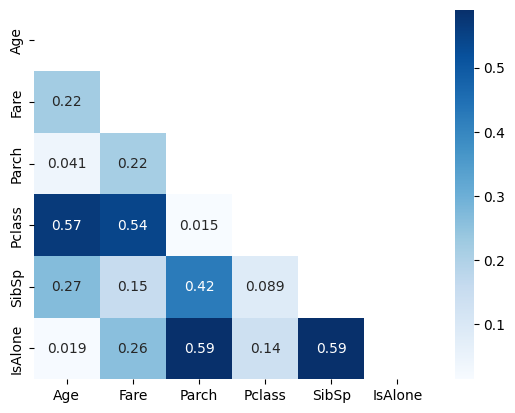

In [15]:
import seaborn as sb
import numpy as np

numerical_features = data_schema.get_features(types=["numerical", "boolean"])

corr = abs(feature_select_train_val_df.correlation(numerical_features)) # type: ignore
mask = np.triu(np.ones_like(corr, dtype=bool))
ax = sb.heatmap(corr, cmap="Blues", mask=mask, annot=True, xticklabels=numerical_features, yticklabels=numerical_features) # type: ignore

In [16]:
data_schema.features

{'numerical': ['Age', 'Fare', 'Parch', 'Pclass', 'SibSp'],
 'categorical': ['Embarked', 'Sex'],
 'boolean': ['IsAlone'],
 'datetime': [],
 'timedelta': []}

In [17]:
feature_select_train_val_df

#,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone
0,1,0,3,1,22.0,1,0,7.25,3,0
1,2,1,1,0,38.0,1,0,71.2833,2,0
2,3,1,3,0,26.0,0,0,7.925,3,1
3,4,1,1,0,35.0,1,0,53.1,3,0
4,5,0,3,1,35.0,0,0,8.05,3,1
...,...,...,...,...,...,...,...,...,...,...
796,885,0,3,1,25.0,0,0,7.05,3,1
797,886,0,3,0,39.0,0,5,29.125,1,0
798,887,0,2,1,27.0,0,0,13.0,3,1
799,888,1,1,0,19.0,0,0,30.0,3,1


# Train Model

In [18]:
train_df, val_df = RandomSplitter(
    cache_directory=f"data/{DATASET_NAME}/split",
    data_split=(0.80, 0.20),
    shuffle=True,
    stratify=TARGET_FEATURE,
    random_state=RANDOM_STATE,
).split(feature_select_train_val_df, cache_group="train_val")

[2023-09-19 17:02:44] [INFO] Cache Hit (LRUCache) RandomSplitter.split: Using cached output. (cache_mixin.py:160)


In [19]:
print_split_stats(train_df, "Train")
print_split_stats(val_df, "Val")
print_split_stats(test_df, "Test")

Train: 38.281% (Survived: 245, Total: 640)
Val: 38.509% (Survived:  62, Total: 161)
Test: 38.889% (Survived:  35, Total:  90)


In [22]:
from mleko.model import LGBMModel

lgbm_model = LGBMModel(
    cache_directory=f"data/{DATASET_NAME}/model",
    objective="binary",
    target=TARGET_FEATURE,
    num_iterations=100,
    ignore_features=META_FEATURES,
    metric=["average_precision", "auc"],
)

model, metrics, p_train_df, p_val_df = lgbm_model.fit_transform(data_schema, train_df, val_df, {})

[2023-09-19 17:02:50] [INFO] Cache Hit (LRUCache) LGBMModel.fit_transform: Using cached output. (cache_mixin.py:160)


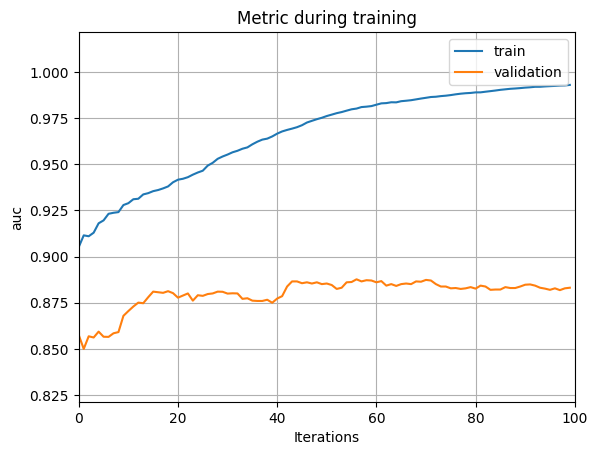

In [23]:
import lightgbm

ax = lightgbm.plot_metric(metrics, metric='auc')

# `mleko` Pipeline

In [24]:
kaggle_ingester = KaggleIngester(
    destination_directory=f"data/{DATASET_NAME}/raw", 
    owner_slug=OWNER_SLUG, 
    dataset_slug=DATASET_SLUG
)

[2023-09-19 17:02:53] [INFO] Attempting to fetch Kaggle API credentials from environment variables 'KAGGLE_USERNAME' and 'KAGGLE_KEY'. (kaggle_ingester.py:74)
[2023-09-19 17:02:53] [INFO] Kaggle API credentials not found in environment variables, attempting to fetch from fallback path at ~/.kaggle/kaggle.json. (kaggle_ingester.py:82)
[2023-09-19 17:02:53] [INFO] Kaggle credentials successfully fetched. (kaggle_ingester.py:91)


In [25]:
csv_to_vaex_converter = CSVToVaexConverter(
    cache_directory=f"data/{DATASET_NAME}/converted",
    drop_columns=["Ticket"],
    meta_columns=META_FEATURES,
    drop_rows_with_na_columns=[TARGET_FEATURE],
    random_state=RANDOM_STATE,
)

In [26]:
random_splitter_90_10 = RandomSplitter(
    cache_directory=f"data/{DATASET_NAME}/split",
    data_split=(0.90, 0.10),
    shuffle=True,
    stratify=TARGET_FEATURE,
    random_state=RANDOM_STATE,
)

In [27]:
composite_transformer = CompositeTransformer(
    cache_directory=f"data/{DATASET_NAME}/transform",
    transformers=[
        FeatureDropperTransformer(
          cache_directory=f"data/{DATASET_NAME}/transform",
            features=["Name"],  
        ),
        IsAloneTransformer(
            cache_directory=f"data/{DATASET_NAME}/transform",
        ),
        LabelEncoderTransformer(
            cache_directory=f"data/{DATASET_NAME}/transform",
            features=["Sex", "Embarked", "IsAlone"],
        ),
    ],
)

In [28]:
composite_feature_selector = CompositeFeatureSelector(
    cache_directory=f"data/{DATASET_NAME}/feature_select",
    feature_selectors=[
        MissingRateFeatureSelector(
            cache_directory=f"data/{DATASET_NAME}/feature_select",
            missing_rate_threshold=0.5,
            ignore_features=META_FEATURES,
        ),
        InvarianceFeatureSelector(
            cache_directory=f"data/{DATASET_NAME}/feature_select",
            ignore_features=META_FEATURES,
        ),
        PearsonCorrelationFeatureSelector(
            cache_directory=f"data/{DATASET_NAME}/feature_select",
            correlation_threshold=0.7,
            ignore_features=META_FEATURES,
        ),
    ],
)

In [29]:
random_splitter_80_20 = RandomSplitter(
    cache_directory=f"data/{DATASET_NAME}/split",
    data_split=(0.80, 0.20),
    shuffle=True,
    stratify=TARGET_FEATURE,
    random_state=RANDOM_STATE,
)

In [67]:
from mleko.pipeline import Pipeline
from mleko.pipeline.steps import IngestStep, ConvertStep, SplitStep, FeatureSelectStep, TransformStep, ModelStep

pre_pipeline = Pipeline(
    steps=[
        IngestStep(kaggle_ingester, outputs=["raw_csv"]),
        ConvertStep(csv_to_vaex_converter, inputs=["raw_csv"], outputs=["clean_data_schema", "clean_df"]),
        SplitStep(
            random_splitter_90_10,
            inputs=["clean_df"],
            outputs=["train_val_clean_df", "test_clean_df"],
            cache_group="train_val_test",
        ),
        TransformStep(
            composite_transformer,
            action="fit_transform",
            inputs=["clean_data_schema", "train_val_clean_df"],
            outputs=["transform_data_schema", "composite_transformer", "transform_train_val_df"],
            cache_group="train_val",
        ),
        TransformStep(
            composite_transformer,
            action="transform",
            inputs=["clean_data_schema", "test_clean_df"],
            outputs=["transform_data_schema", "transform_test_df"],
            cache_group="test",
        ),
        FeatureSelectStep(
            composite_feature_selector,
            action="fit_transform",
            inputs=["transform_data_schema", "transform_train_val_df"],
            outputs=["data_schema", "composite_feature_selector", "selected_train_val_df"],
            cache_group="train_val",
        ),
        FeatureSelectStep(
            composite_feature_selector,
            action="transform",
            inputs=["transform_data_schema", "transform_test_df"],
            outputs=["data_schema", "test_df"],
            cache_group="test",
        ),
        SplitStep(
            random_splitter_80_20,
            inputs=["selected_train_val_df"],
            outputs=["train_df", "val_df"],
            cache_group="train_val",
        ),
    ]
)

pre_pipeline


Pipeline:
  1. IngestStep(ingester=KaggleIngester(file_names=None, dataset_version=None, kaggle_api_credentials_file=None, num_workers=64, destination_directory='data/yasserh/titanic-dataset/raw', owner_slug='yasserh', dataset_slug='titanic-dataset'), inputs=(), outputs=['raw_csv'])
  2. ConvertStep(converter=CSVToVaexConverter(forced_numerical_columns=(), forced_categorical_columns=(), forced_boolean_columns=(), drop_columns=['Ticket'], meta_columns=['PassengerId', 'Survived'], drop_rows_with_na_columns=['Survived'], na_values=('-9998', '-9998.0', '-9999', '-9999.0', '-99', '-99.0', 'nan', 'none', 'non', 'Nan', 'None', 'Non', '', 'N/A', 'N/a', 'unknown', 'missing'), true_values=('t', 'True', 'true', '1'), false_values=('f', 'False', 'false', '0'), downcast_float=False, random_state=1337, num_workers=12, cache_size=1, cache_directory='data/yasserh/titanic-dataset/converted'), inputs=['raw_csv'], outputs=['clean_data_schema', 'clean_df'], cache_group=None)
  3. SplitStep(splitter=Random

In [68]:
pre_data_container = pre_pipeline.run()

[2023-09-19 17:25:33] [INFO] No data container provided. Creating an empty one. (pipeline.py:77)
[2023-09-19 17:25:33] [INFO] Executing step 1/8: IngestStep. (pipeline.py:81)
[2023-09-19 17:25:33] [INFO] Cache Hit: Local dataset is up to date with Kaggle, skipping download. (kaggle_ingester.py:279)
[2023-09-19 17:25:33] [INFO] Finished step 1/8 execution. (pipeline.py:83)
[2023-09-19 17:25:33] [INFO] Executing step 2/8: ConvertStep. (pipeline.py:81)
[2023-09-19 17:25:34] [INFO] Cache Hit (LRUCache) CSVToVaexConverter.convert: Using cached output. (cache_mixin.py:160)
[2023-09-19 17:25:34] [INFO] Finished step 2/8 execution. (pipeline.py:83)
[2023-09-19 17:25:34] [INFO] Executing step 3/8: SplitStep. (pipeline.py:81)
[2023-09-19 17:25:34] [INFO] Cache Hit (LRUCache) RandomSplitter.split: Using cached output. (cache_mixin.py:160)
[2023-09-19 17:25:34] [INFO] Finished step 3/8 execution. (pipeline.py:83)
[2023-09-19 17:25:34] [INFO] Executing step 4/8: TransformStep. (pipeline.py:81)
[202

In [75]:
lgbm_model = LGBMModel(
    cache_directory=f"data/{DATASET_NAME}/model",
    objective="binary",
    target=TARGET_FEATURE,
    num_iterations=100,
    ignore_features=META_FEATURES,
    metric=["average_precision", "auc"],
)

model_pipeline = Pipeline(
    steps=[
        ModelStep(
            lgbm_model,
            action="fit_transform",
            inputs=["data_schema", "train_df", "val_df"],
            outputs=["lgbm_model", "metrics", "pred_train_df", "pred_val_df"],
        ),
        ModelStep(
            lgbm_model,
            action="transform",
            inputs=["data_schema", "test_df"],
            outputs=["pred_test_df"],
        ),
    ]
)

In [77]:
data_container = model_pipeline.run(data_container=pre_data_container)
result = data_container.data

list(result.keys())

[2023-09-19 17:28:55] [INFO] Executing step 1/2: ModelStep. (pipeline.py:81)
[2023-09-19 17:28:55] [INFO] Cache Hit (LRUCache) LGBMModel.fit_transform: Using cached output. (cache_mixin.py:160)
[2023-09-19 17:28:55] [INFO] Finished step 1/2 execution. (pipeline.py:83)
[2023-09-19 17:28:55] [INFO] Executing step 2/2: ModelStep. (pipeline.py:81)
[2023-09-19 17:28:55] [INFO] Cache Hit (LRUCache) LGBMModel.transform: Using cached output. (cache_mixin.py:160)
[2023-09-19 17:28:55] [INFO] Finished step 2/2 execution. (pipeline.py:83)


['raw_csv',
 'clean_data_schema',
 'clean_df',
 'train_val_clean_df',
 'test_clean_df',
 'transform_data_schema',
 'composite_transformer',
 'transform_train_val_df',
 'transform_test_df',
 'data_schema',
 'composite_feature_selector',
 'selected_train_val_df',
 'test_df',
 'train_df',
 'val_df',
 'lgbm_model',
 'metrics',
 'pred_train_df',
 'pred_val_df',
 'pred_test_df']

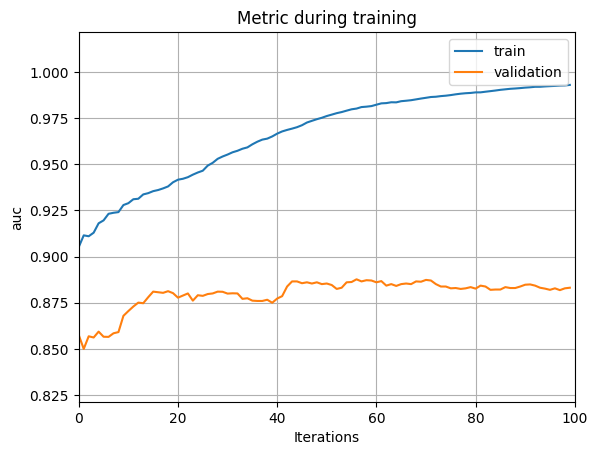

In [78]:
ax = lightgbm.plot_metric(result["metrics"], metric='auc')